# GOES Visible Satellite Images
### Channels avaliable in this notebook are:
* 1 - Blue:  0.47 $\mu m$
* 2 - Red:  0.64 $\mu m$
* 3 - Near IR (Veggie Green):  0.86 $\mu m$

Plot 2 main images: 

* Visible - Red (Band 2) 

* True Color RGB: Band 2, Band 3, Band 1

## Justin Richling
## 09/20/18

## This is an incredible tutorial from Brian Blayblock - check out his notebooks!

https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/GOES16_TrueColor_Cartopy.ipynb

## Imports

In [1]:
# Random Library Imports
import subprocess,os,glob,tempfile,re,webbrowser,io,sys,types,urllib,\
time

# Importing Datetime Libraries
from datetime import datetime, date

# CartoPy Map Plotting Libraires
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj 

# Numerical and Scientific Libraries
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

# Accessing Data from External Databases via XLM Catalog
from siphon.ncss import NCSS
from siphon.catalog import TDSCatalog

# MetPy Libraries
import metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import ctables
from metpy.plots import add_metpy_logo
from metpy.plots.ctables import registry
from metpy.plots import add_timestamp

# NetCDF Libraries
from netCDF4 import Dataset
from netCDF4 import num2date

# More Image Manipulation Options
import PIL
from PIL import Image as PILImage

# Ipyhton Options
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML, display, Image

# Matplotlib Plotting Libraries
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patheffects

/Users/chowdahead/miniconda3/lib/python3.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


In [2]:
# Unidata/MetPy Dictionary of GOES channels

channel_list = {u'1 - Blue Band 0.47 \u03BCm': 1,
                u'2 - Red Band 0.64 \u03BCm': 2,
                u'3 - Veggie Band 0.86 \u03BCm': 3,
                u'4 - Cirrus Band 1.37 \u03BCm': 4,
                u'5 - Snow/Ice Band 1.6 \u03BCm': 5,
                u'6 - Cloud Particle Size Band 2.2 \u03BCm': 6,
                u'7 - Shortwave Window Band 3.9 \u03BCm': 7,
                u'8 - Upper-Level Tropo. WV Band 6.2 \u03BCm': 8,
                u'9 - Mid-Level Tropo. WV Band 6.9 \u03BCm': 9,
                u'10 - Low-Level WV Band 7.3 \u03BCm': 10,
                u'11 - Cloud-Top Phase Band 8.4 \u03BCm': 11,
                u'12 - Ozone Band 9.6 \u03BCm': 12,
                u'13 - Clean IR Longwave Band 10.3 \u03BCm': 13,
                u'14 - IR Longwave Band 11.2 \u03BCm': 14,
                u'15 - Dirty Longwave Band 12.3 \u03BCm': 15,
                u'16 - CO2 Longwave IR 13.3 \u03BCm': 16}

# Archived Data

In [3]:
# Set the date you want to convert
dt = datetime(2019, 7, 10, 0, 1)
#dt = now

# Start of year for reference
d0 = datetime(2019, 1, 1, 0, 1)

# Find the difference and add one to get the day number of the calander year
print(dt)
delta = dt - d0
Julian_Day = delta.days+1
if Julian_Day < 100:
    Julian_Day = "0"+str(Julian_Day)
    if int(Julian_Day) < 10:
        Julian_Day = "0"+str(Julian_Day)

Year = str('{0:%Y}'.format(dt))
Month = str('{0:%m}'.format(dt))
Day = str('{0:%d}'.format(dt))
Hour = str('{0:%H}'.format(dt))
Minute = str('{0:%m}'.format(dt))
print(Minute)
#'{0:%Y}'.format(dt)+"-"+'{0:%m}'.format(dt)+"-"+'{0:%d}'.format(dt)+"-"+'{0:%H}'.format(dt)
print("date: ",Year+"-"+Month+"-"+Day+"-"+Hour+"-"+Minute)

# Julian day (Day)
print("Julian number: ",Julian_Day)

2019-07-10 00:01:00
07
date:  2019-07-10-00-07
Julian number:  191


In [3]:
Julian_Day = 185

In [4]:
# Where the data is supposed to be
GOES_sample_path = '/Users/chowdahead/Downloads/GOES_Data/'+str(Year)+'/'+str(Julian_Day)+'/' # Use full path to file
print("Data path:",GOES_sample_path)
# Check to see if the folder already exists, if not create it
if not os.path.isdir(GOES_sample_path):
    os.makedirs(GOES_sample_path)
    

# Set a path to save the plots with string format for the date to set the month and day
# This will be where the images will be saved
save_path = "/Users/ChowdaHead/Desktop/Weather_Blog/GOES/"+Year+'/'+str(Julian_Day)+'/'
save_path = save_path+"True_Color/"
print("save path:",save_path)

# Check to see if the folder already exists, if not create it
if not os.path.isdir(save_path):
    os.makedirs(save_path)
    

# Old way of getting the files via this website, 
Webpage = "http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi"+\
    "?source=aws&domain=C&product=ABI-L1b-Rad&date="+\
    '{0:%Y}'.format(dt)+"-"+'{0:%m}'.format(dt)+"-"+'{0:%d}'.format(dt)+"&hour="+'{0:%H}'.format(dt)

#webbrowser.open(Webpage)


Data path: /Users/chowdahead/Downloads/GOES_Data/2019/191/
save path: /Users/ChowdaHead/Desktop/Weather_Blog/GOES/2019/191/True_Color/


# --------------------------------------------------------------------------------------------

# Populate the Lists for Different Channels

In [5]:
# Check to make sure the data went to the right path
GOES_sample_path

'/Users/chowdahead/Downloads/GOES_Data/2019/185/'

# GOES-17 Files...

In [9]:
GOES_sample_path+str(18)+'/'

'/Users/chowdahead/Downloads/GOES_Data/2019/191/18/'

In [12]:
GOES16_samples_9 = []
for name in glob.glob(GOES_sample_path+str(18)+'/OR_ABI-L2-CMIPC-M6*.nc'):
    GOES16_samples_9.append(name)
    #for name in glob.glob(GOES_sample_path+'OR*L2*RadC*C09*G16*s'+Year+str(Julian_Day)+'*.nc'):
    #    GOES16_samples_9.append(name)
    GOES16_samples_9 = [os.path.join(GOES_sample_path, s) for s in GOES16_samples_9]
    GOES16_samples_9 = sorted(GOES16_samples_9, key=lambda x: int(re.sub('\D', '', x)))
print(len(GOES16_samples_9))
print(GOES16_samples_9[-1])

12
/Users/chowdahead/Downloads/GOES_Data/2019/191/18/OR_ABI-L2-CMIPC-M6C13_G16_s20191911856318_e20191911859103_c20191911859165.nc


In [15]:
ch13nc = Dataset(GOES16_samples_9[-1])
data_IR = ch13nc.variables['CMI'][:]
        #ch2nc.close()
        #ch2nc = None

print(ch13nc)    
sat_h = ch13nc.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
#sat_lon = nc.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
#sat_sweep = nc.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = ch13nc.variables['x'][:] * sat_h
Y = ch13nc.variables['y'][:] * sat_h

# Set the projections for plotting 
proj_var = ch13nc.variables['goes_imager_projection']
sat_height = proj_var.perspective_point_height
central_lon = proj_var.longitude_of_projection_origin
semi_major = proj_var.semi_major_axis
semi_minor = proj_var.semi_minor_axis
print(semi_major,semi_minor,central_lon,sat_height)
# Set Projection of Plot
#globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
#crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height)#, globe=globe

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v35, 20 July 2016)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 2km at nadir
    orbital_slot: GOES-East
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: CONUS
    instrument_ID: FM1
    dataset_name: OR_ABI-L2-CMIPC-M6C13_G16_s20191911856318_e20191911859103_c20191911859165.nc
    iso_series_metadata_id: 8c9e8150-3692-11e3-aa6e-0800200c9a66
    title: ABI L2 Cloud and Moisture Imagery
    summary: Single emissive band Cloud and Moisture Imagery Products are d

In [6]:
GOES16_samples_9 = []
for i in range(0,24):
    if i < 10:
        hour = "0"+str(i)
    else:
        hour = i
    print(hour)
    for name in glob.glob(GOES_sample_path+str(18)+'/OR_ABI-L2-MCMIPC-M6_G16*.nc'):
        GOES16_samples_9.append(name)
    #for name in glob.glob(GOES_sample_path+'OR*L2*RadC*C09*G16*s'+Year+str(Julian_Day)+'*.nc'):
    #    GOES16_samples_9.append(name)
    GOES16_samples_9 = [os.path.join(GOES_sample_path, s) for s in GOES16_samples_9]
    GOES16_samples_9 = sorted(GOES16_samples_9, key=lambda x: int(re.sub('\D', '', x)))
print(len(GOES16_samples_9))
print(GOES16_samples_9[-1])

00
01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0


IndexError: list index out of range

# Single images here; loops are further down in the notebook

### Set the lat/lon extent of the map

In [16]:
# Lon/Lat Box

# [Lon_0, Lon_1, Lat_0, Lat_1]
# CONUS
extent = [-120., -70, 20., 50.] 
extent = [-110., -100, 37., 42.] 
extent = [-101., -93, 33.5, 37.5] # Oklahoma

## True Color

Source for working code - super useful and almost turn-key

http://edc.occ-data.org/goes16/python/#psuedo-true-color-image

In [18]:
import xarray as xarray

In [19]:
cd ~/Downloads/GOES_Data/2019/185/18/

/Users/chowdahead/Downloads/GOES_Data/2019/185/18


In [2]:
ls

OR_ABI-L1b-RadC-M6C01_G16_s20191851801261_e20191851804034_c20191851804081.nc
OR_ABI-L1b-RadC-M6C01_G16_s20191851806261_e20191851809034_c20191851809079.nc
OR_ABI-L1b-RadC-M6C01_G16_s20191851811261_e20191851814034_c20191851814083.nc
OR_ABI-L1b-RadC-M6C01_G16_s20191851816261_e20191851819034_c20191851819082.nc
OR_ABI-L1b-RadC-M6C01_G16_s20191851821261_e20191851824034_c20191851824081.nc
OR_ABI-L1b-RadC-M6C01_G16_s20191851826261_e20191851829034_c20191851829080.nc
OR_ABI-L1b-RadC-M6C01_G16_s20191851831261_e20191851834034_c20191851834083.nc
OR_ABI-L1b-RadC-M6C01_G16_s20191851836261_e20191851839034_c20191851839081.nc
OR_ABI-L1b-RadC-M6C01_G16_s20191851841261_e20191851844034_c20191851844081.nc
OR_ABI-L1b-RadC-M6C01_G16_s20191851846261_e20191851849034_c20191851849083.nc
OR_ABI-L1b-RadC-M6C01_G16_s20191851851261_e20191851854034_c20191851854083.nc
OR_ABI-L1b-RadC-M6C01_G16_s20191851856261_e20191851859034_c20191851859079.nc
OR_ABI-L2-MCMIPC-M6_G16_s20191851801261_e20191851804034_c20191851804149.nc
O

In [20]:
#nc = Dataset(GOES16_samples_9[10])
nc = xarray.open_dataset("OR_ABI-L2-MCMIPC-M6_G16_s20191851801261_e20191851804034_c20191851804149.nc")

In [21]:
for band in [2, 3, 1]:
    print("%s is %.2f %s" % (nc['band_wavelength_C%02d' % band].long_name,
                             nc['band_wavelength_C%02d' % band][0],
                             nc['band_wavelength_C%02d' % band].units))

ABI band 2 central wavelength is 0.64 um
ABI band 3 central wavelength is 0.87 um
ABI band 1 central wavelength is 0.47 um


In [22]:
list(nc.variables)

['CMI_C01',
 'DQF_C01',
 'CMI_C02',
 'DQF_C02',
 'CMI_C03',
 'DQF_C03',
 'CMI_C04',
 'DQF_C04',
 'CMI_C05',
 'DQF_C05',
 'CMI_C06',
 'DQF_C06',
 'CMI_C07',
 'DQF_C07',
 'CMI_C08',
 'DQF_C08',
 'CMI_C09',
 'DQF_C09',
 'CMI_C10',
 'DQF_C10',
 'CMI_C11',
 'DQF_C11',
 'CMI_C12',
 'DQF_C12',
 'CMI_C13',
 'DQF_C13',
 'CMI_C14',
 'DQF_C14',
 'CMI_C15',
 'DQF_C15',
 'CMI_C16',
 'DQF_C16',
 't',
 'y',
 'x',
 'time_bounds',
 'goes_imager_projection',
 'y_image',
 'y_image_bounds',
 'x_image',
 'x_image_bounds',
 'nominal_satellite_subpoint_lat',
 'nominal_satellite_subpoint_lon',
 'nominal_satellite_height',
 'geospatial_lat_lon_extent',
 'band_wavelength_C01',
 'band_wavelength_C02',
 'band_wavelength_C03',
 'band_wavelength_C04',
 'band_wavelength_C05',
 'band_wavelength_C06',
 'band_wavelength_C07',
 'band_wavelength_C08',
 'band_wavelength_C09',
 'band_wavelength_C10',
 'band_wavelength_C11',
 'band_wavelength_C12',
 'band_wavelength_C13',
 'band_wavelength_C14',
 'band_wavelength_C15',
 'ba

In [23]:
red = nc.variables['CMI_C01'][:]
green = nc.variables['CMI_C03'][:]
blue = nc.variables['CMI_C02'][:]


#red = c.variables['CMI_C01'].data
#green = c.variables['CMI_C03'].data
#blue = c.variables['CMI_C02'].data

In [24]:
red = np.clip(red,0,1)
green = np.clip(green,0,1)
blue = np.clip(blue,0,1)

# $Red = Red^{\frac{1}{\gamma}}$

### $\gamma = 2.2$

In [25]:
gamma = 2.2
red = np.power(red,1/gamma)
green = np.power(green,1/gamma)
blue = np.power(blue, 1/gamma)

In [26]:
green_true = 0.45*red + 0.1*green + 0.45*blue
green_true = np.clip(green_true,0,1)
#green_true = (0.48358168*red) + (0.06038137*green) + (0.45706946*blue)
#green_true = np.power(green_true, 1/gamma)

In [27]:
green_true = np.maximum(green_true, 0)
green_true = np.minimum(green_true, 1)
#green_true = np.clip(green_true,0,1)

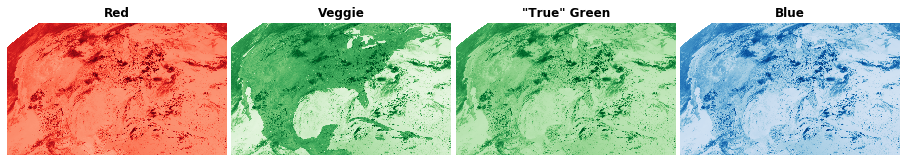

In [28]:
fig, ([ax1, ax2, ax3, ax4]) = plt.subplots(1, 4, figsize=(16, 3))

ax1.imshow(red, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('Red', fontweight='semibold')
ax1.axis('off')

ax2.imshow(green, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('Veggie', fontweight='semibold')
ax2.axis('off')

ax3.imshow(green_true, cmap='Greens', vmax=1, vmin=0)
ax3.set_title('"True" Green', fontweight='semibold')
ax3.axis('off')

ax4.imshow(blue, cmap='Blues', vmax=1, vmin=0)
ax4.set_title('Blue', fontweight='semibold')
ax4.axis('off')

plt.subplots_adjust(wspace=.02)


In [29]:
rgb = np.stack([red,green_true,blue], axis=2)
rgb_eh = np.dstack([red,green,blue])

In [1]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 3))

ax1.imshow(rgb)
ax1.set_title('True RGB', fontweight='semibold')
ax1.axis('off')

ax2.imshow(rgb_eh)
ax2.set_title('Veggie RGB', fontweight='semibold')
ax2.axis('off')

NameError: name 'plt' is not defined